# Training Time #

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tutorial_util as util
import json
import os
from collections import defaultdict
from scipy.stats import ttest_ind
from functools import reduce

In [2]:
%matplotlib inline

In [3]:
os.getcwd()

'/home/cstseng/Documents/strata_bias_demo'

In [4]:
# with open('/data_knlzeug02/DATASETS/berkely-deepdrive/bdd100k/labels/bdd100k_labels_images_val.json', 'r') as f:
#     val_labels = json.load(f)

In [8]:
def format_labels(images):
    format_labels = []
    for img in images:
        
        for l in img['labels']:
            if l['category'] != 'person':
                continue
            else:
                item = {}
                item['name'] = img['name']
                item['timeofday'] = img['attributes']['timeofday']
                item['occluded']  = l['attributes']['occluded']
                item['truncated'] = l['attributes']['truncated']
                item['bbox'] = [l['box2d']['x1'], l['box2d']['y1'], l['box2d']['x2'], l['box2d']['y2']]
                
                format_labels.append(item)
    return format_labels
#gt = format_labels(val_labels)


In [6]:
def group_by_key(detections, key):
    groups = defaultdict(list)
    for d in detections:
        groups[d[key]].append(d)
    return groups

# cat_gt = group_by_key(gt, 'timeofday')
# cat_gt.keys()

In [ ]:
# cat_day_gt = group_by_key(cat_gt['daytime'], 'occluded')
# cat_day_gt.keys()

In [37]:
# calculate number of pedestrians in labels??
with open ('../algoFairness_ww40.2/gt_day.json', 'r') as f:
    orig_gt_day = json.load(f)
with open ('../algoFairness_ww40.2/gt_night.json', 'r') as f:
    orig_gt_night = json.load(f) 
    
dd_day_detection = np.load('../algoFairness_ww40.2/dd_day_detection.npy')
dd_night_detection = np.load('../algoFairness_ww40.2/dd_night_detection.npy')
    
dn_day_detection = np.load('../algoFairness_ww40.2/dn_day_detection.npy')
dn_night_detection = np.load('../algoFairness_ww40.2/dn_night_detection.npy')

nd_day_detection = np.load('../algoFairness_ww40.2/nd_day_detection.npy')
nd_night_detection = np.load('../algoFairness_ww40.2/nd_night_detection.npy')


In [18]:
print('len gt day', len(orig_gt_day))
print('len gt night', len(orig_gt_night))
print('len detect day', len(dn_day_detection))
print('len detect night', len(dn_night_detection))

len gt day 594
len gt night 837
len detect day 598
len detect night 837


In [12]:
def format_split_labels(images):
    format_labels = []
    for img in images:
        
        for cnt, l in enumerate(img['classes']):
            item = {}
            item['name'] = img['name']
            item['timeofday'] = img['timeofday']
            item['occluded']  = img['occluded'][cnt]
            item['bbox'] = [img['bbox_xmin'][cnt], 
                            img['bbox_ymin'][cnt],
                            img['bbox_xmax'][cnt],
                            img['bbox_ymax'][cnt]]
                
            format_labels.append(item)
    return format_labels

gt_day = format_split_labels(orig_gt_day)
gt_night = format_split_labels(orig_gt_night)

In [21]:
gt_day[0]

{'name': 'b1d0a191-06deb55d.jpg',
 'timeofday': 'daytime',
 'occluded': False,
 'bbox': [62.268335, 271.041167, 107.784948, 382.630285]}

In [39]:
def format_pred(predictions):
    format_pred = []
    for img in predictions:
        
        for idx in range(int(img['num_detections'])):
            item = {}
            item['name'] = img['name']
            item['bbox']  = [img['scaled_detection_boxes'][idx][1], img['scaled_detection_boxes'][idx][0],
                            img['scaled_detection_boxes'][idx][3], img['scaled_detection_boxes'][idx][2]]
            
            item['score'] = img['detection_scores'][idx]

            format_pred.append(item)
    return format_pred


dd_day_pred = format_pred(dd_day_detection)
dd_night_pred = format_pred(dd_night_detection)

dn_day_pred = format_pred(dn_day_detection)
dn_night_pred = format_pred(dn_night_detection)

nd_day_pred = format_pred(nd_day_detection)
nd_night_pred = format_pred(nd_night_detection)

In [16]:
print('len gt day', len(gt_day))
print('len gt night', len(gt_night))
print('len detect day', len(dn_day_pred))
print('len detect night', len(dn_night_pred))

len gt day 2843
len gt night 2843
len detect day 2393
len detect night 2488


In [73]:
def get_ap(recalls, precisions):
    # correct AP calculation
    # first append sentinel values at the end
    recalls = np.concatenate(([0.], recalls, [1.]))
    precisions = np.concatenate(([0.], precisions, [0.]))

    # compute the precision envelope
    for i in range(precisions.size - 1, 0, -1):
        precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(recalls[1:] != recalls[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])
    return ap

def cat_pc(gt, predictions, thresholds):
    """
    Implementation refers to https://github.com/rbgirshick/py-faster-rcnn
    """
    num_gts = len(gt)
    image_gts = group_by_key(gt, 'name')
    image_gt_boxes = {k: np.array([[float(z) for z in b['bbox']]
                                   for b in boxes])
                      for k, boxes in image_gts.items()}
    image_gt_checked = {k: np.zeros((len(boxes), len(thresholds)))
                        for k, boxes in image_gts.items()}
    image_gt_occluded = {k: np.array([b['occluded']
                                   for b in boxes])
                      for k, boxes in image_gts.items()}
    
    num_gts_occluded = reduce(lambda x, y: int(x) + int(y), [i['occluded'] for i in gt])
    
    predictions = sorted(predictions, key=lambda x: x['score'], reverse=True)

    # go down dets and mark TPs and FPs
    nd = len(predictions)
    tp = np.zeros((nd, len(thresholds)))
    fp = np.zeros((nd, len(thresholds)))
    
    nd_occ = len(predictions)
    tp_occ = np.zeros((nd, len(thresholds)))
    fp_occ = np.zeros((nd, len(thresholds)))
    
    nd_nocc = len(predictions)
    tp_nocc = np.zeros((nd, len(thresholds)))
    fp_nocc = np.zeros((nd, len(thresholds)))
    
    for i, p in enumerate(predictions):
        box = p['bbox']
        #print('name', p['name'], i)
        ovmax = -np.inf
        jmax = -1
        try:
            gt_boxes = image_gt_boxes[p['name']]
            gt_checked = image_gt_checked[p['name']]
            gt_occluded = image_gt_occluded[p['name']]
        except KeyError:
            print('name', p['name'] ,"does not exist in gt")
            gt_boxes = []
            gt_checked = None
            gt_occluded = None
            # todo: remove later
            continue
            
        if len(gt_boxes) > 0:
            # compute overlaps
            # intersection
            ixmin = np.maximum(gt_boxes[:, 0], box[0])
            iymin = np.maximum(gt_boxes[:, 1], box[1])
            ixmax = np.minimum(gt_boxes[:, 2], box[2])
            iymax = np.minimum(gt_boxes[:, 3], box[3])
            iw = np.maximum(ixmax - ixmin + 1., 0.)
            ih = np.maximum(iymax - iymin + 1., 0.)
            inters = iw * ih

            # union
            uni = ((box[2] - box[0] + 1.) * (box[3] - box[1] + 1.) +
                   (gt_boxes[:, 2] - gt_boxes[:, 0] + 1.) *
                   (gt_boxes[:, 3] - gt_boxes[:, 1] + 1.) - inters)

            overlaps = inters / uni
            ovmax = np.max(overlaps)
            jmax = np.argmax(overlaps)
            #print('length of gt boxes', len(gt_boxes), 'ovmax', ovmax, 'jmax', jmax,
            #     'box', box, 'gt_boxes', gt_boxes)
            
        for t, threshold in enumerate(thresholds):
            if ovmax > threshold:
                if gt_checked[jmax, t] == 0:
                    if gt_occluded[jmax] == True:
                        tp_occ[i, t] = 1.
                    else:
                        tp_nocc[i, t] = 1.
                    tp[i, t] = 1
                    gt_checked[jmax, t] = 1
                else:
                    if gt_occluded[jmax] == True:
                        fp_occ[i, t] = 1.
                    else:
                        fp_nocc[i, t] = 1.
                    fp[i, t] = 1.
            else:
                if gt_occluded[jmax] == True:
                    fp_occ[i, t] = 1.
                else:
                    fp_nocc[i, t] = 1.
                fp[i, t] = 1.

    # compute precision recall
    fp = np.cumsum(fp, axis=0)
    tp = np.cumsum(tp, axis=0)
    recalls = tp / float(num_gts)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    precisions = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = np.zeros(len(thresholds))
    
    # occluded
    fp_occ = np.cumsum(fp_occ, axis=0)
    tp_occ = np.cumsum(tp_occ, axis=0)
    recalls_occ = tp_occ / float(num_gts_occluded) # probaly should divide by number of occluded
    precisions_occ = tp_occ / np.maximum(tp_occ + fp_occ, np.finfo(np.float64).eps)
    ap_occ = np.zeros(len(thresholds))
    
    # not occluded
    fp_nocc = np.cumsum(fp_nocc, axis=0)
    tp_nocc = np.cumsum(tp_nocc, axis=0)
    recalls_nocc = tp_nocc / float((num_gts - num_gts_occluded)) # probaly should divide by number of occluded
    precisions_nocc = tp_nocc / np.maximum(tp_nocc + fp_nocc, np.finfo(np.float64).eps)
    ap_nocc = np.zeros(len(thresholds))
    
    for t in range(len(thresholds)):
        ap[t] = get_ap(recalls[:, t], precisions[:, t])
        ap_occ[t] = get_ap(recalls_occ[:, t], precisions_occ[:, t])
        ap_nocc[t] = get_ap(recalls_nocc[:, t], precisions_nocc[:, t])

    return ap, ap_occ, ap_nocc, \
            tp[-1], tp_occ[-1], tp_nocc[-1], num_gts, num_gts_occluded

#def evaluate_detection(gt_path, result_path):
def evaluate_detection(gt, pred, metric=None):
    thresholds = [0.75]
    aps = np.zeros((len(thresholds)))
    ap, ap_oc, ap_noc, tp, tp_occ, tp_nocc, num_gts, num_gts_oc = cat_pc(gt, pred, thresholds)
    print('has Average Precision', ap, 'Occluded Average Precision', ap_oc, 
          'non-Occluded Average Precision', ap_noc, 'num_gts', num_gts, 'num_gts_oc', num_gts_oc,
         'r', tp/num_gts, 'r_occ', tp_occ/num_gts_oc, 'r_nocc', tp_nocc/(num_gts - num_gts_oc))
    
    result = {}
    if metric == 'ap':
        result['recall'] = ap
        result['recall_oc'] = ap_oc
        result['recall_noc'] = ap_noc
        result['num_gts'] = num_gts
        result['num_gts_oc'] = num_gts_oc
        return result
    
    result['recall'] = tp[0]/num_gts
    result['recall_oc'] = tp_occ[0]/num_gts_oc
    result['recall_noc'] = tp_nocc[0]/(num_gts - num_gts_oc)
    result['num_gts'] = num_gts
    result['num_gts_oc'] = num_gts_oc
    return result


In [74]:
# calculate mean difference
print('day night eq')
dn_day_result = evaluate_detection(gt_day, dn_day_pred)
dn_night_result = evaluate_detection(gt_night, dn_night_pred)


day night eq
name b1cd1e94-549d0bfe.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg does not exist in gt
has Average Precision [0.17604646] Occluded Average Precision [0.06313866] 

In [75]:

# calculate conditional difference
def calc_unexp_diff(day_result, night_result):
    mean_diff = day_result['recall'] - night_result['recall']
    occ_accp = (day_result['recall_oc'] + night_result['recall_oc'])/2
    nocc_accp = (day_result['recall_noc'] + night_result['recall_noc'])/2
    prob_occ_night = night_result['num_gts_oc'] / night_result['num_gts']
    prob_nocc_night = (night_result['num_gts'] - night_result['num_gts_oc']) / night_result['num_gts']
    prob_occ_day = day_result['num_gts_oc'] / day_result['num_gts']
    prob_nocc_day = (day_result['num_gts'] - day_result['num_gts_oc']) / day_result['num_gts']

    #print('occ_accp',occ_accp,'prob_occ_day', prob_occ_day, 'prob_occ_night', prob_occ_night)
    #print('nocc_accp',nocc_accp, 'prob_nocc_day', prob_nocc_day, 'prob_nocc_night', prob_nocc_night)
    exp_diff = occ_accp * (prob_occ_day - prob_occ_night) + nocc_accp * (prob_nocc_day - prob_nocc_night)
    
    unexp_diff = mean_diff - exp_diff

    print('mean difference', mean_diff, 'exp diff', exp_diff, 'unexp_diff', unexp_diff)
    
    return mean_diff, exp_diff

dn_mean_diff, dn_exp_diff = calc_unexp_diff(dn_day_result,dn_night_result)

mean difference 0.03974674639465353 exp diff -0.006518399197221605 unexp_diff 0.04626514559187514


In [76]:
# calculate day dom
print('day dominate')
dd_day_result = evaluate_detection(gt_day, dd_day_pred)
dd_night_result = evaluate_detection(gt_night, dd_night_pred)
dd_mean_diff, dd_exp_diff = calc_unexp_diff(dd_day_result, dd_night_result)


day dominate
name b1cd1e94-549d0bfe.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg 

In [77]:
# calculate day dom
print('night dominate')
nd_day_result = evaluate_detection(gt_day, nd_day_pred)
nd_night_result = evaluate_detection(gt_night, nd_night_pred)
nd_mean_diff, nd_exp_diff = calc_unexp_diff(nd_day_result, nd_night_result)

night dominate
name b1cd1e94-549d0bfe.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg does not exist in gt
name b1d0a191-2ed2269e.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jpg does not exist in gt
name b1d0a191-03dcecc2.jp

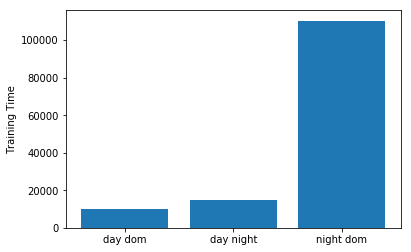

In [78]:
training_time = [10000, 15000, 110310]
model_labels = ['day dom', 'day night', 'night dom']

plt.bar(range(0,3), training_time)
plt.ylabel('Training Time')
plt.xticks(range(0,3), model_labels)
plt.show()

# Dataset Distributions #

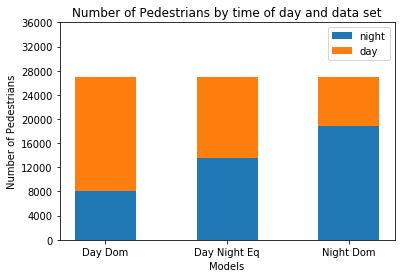

In [79]:
# training data distribution
N = 3
night_person = (8089, 13497, 18898)
day_person = ( 18898, 13498, 8092)
ind = np.arange(N)

pnight = plt.bar(ind, night_person, width=0.5)
pday = plt.bar(ind, day_person , width=0.5, bottom=night_person)

plt.ylabel('Number of Pedestrians')
plt.xlabel('Models')
plt.title('Number of Pedestrians by time of day and data set')
plt.xticks(ind, ('Day Dom', 'Day Night Eq', 'Night Dom'))
plt.yticks(np.arange(0, 38000, 4000))
plt.legend((pnight[0], pday[0]), ('night', 'day'))

plt.show()

## Results ##

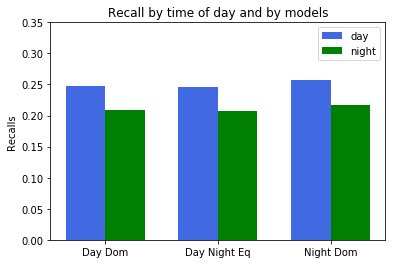

In [80]:
data = {}
data['training_time'] = [10000, 15000, 110310]

gridnumber = np.arange(3)
width = 0.35
fig = plt.figure()
ax = plt.subplot(111)
day_recall = ax.bar(gridnumber, [dd_day_result['recall'], dn_day_result['recall'], nd_day_result['recall']], width, color='royalblue')
night_recall = ax.bar(gridnumber + width, [dd_night_result['recall'], dn_night_result['recall'], nd_night_result['recall']], width, color='green')
ax.set_xticks(gridnumber + width/2)
ax.set_xticklabels(['Day Dom', 'Day Night Eq', 'Night Dom'])   
ax.set_ylabel('Recalls')
ax.set_title('Recall by time of day and by models')
ax.set_ylim((0, 0.35))
ax.legend((day_recall[0], night_recall[1]), ('day', 'night'))


Text(0.5, 1.0, 'Number of training steps vs datasets')

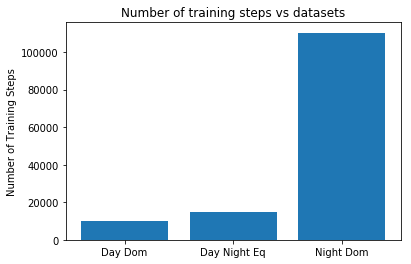

In [52]:
training_times = [10000, 15000, 110310]
plt.bar(gridnumber, training_times)
plt.xticks(gridnumber, ['Day Dom', 'Day Night Eq', 'Night Dom'])
plt.ylabel('Number of Training Steps')
plt.title('Number of training steps vs datasets')